In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import mplhep as hep
from scipy.stats import norm
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline
def configure_plotting():
    plt.rcParams['figure.facecolor'] = 'white'
    plt.rcParams['savefig.facecolor'] = 'white'
    plt.rcParams['savefig.bbox'] = 'tight'
    hep.style.use(hep.style.CMS)

# --- Load the pickle file ---
files = ["jets_Q2_1.pkl", "jets_Q2_10.pkl", "jets_Q2_100.pkl"]

closest_pairs_list = []
unpaired_reco_list = []
unpaired_truth_list = []

for f in files:
    data = pd.read_pickle(f)
    closest_pairs_list.append(data["closest_pairs"])
    unpaired_reco_list.append(data["unpaired_reco"])
    unpaired_truth_list.append(data["unpaired_truth"])

closest_pairs = pd.concat(closest_pairs_list, ignore_index=True)
unpaired_reco = pd.concat(unpaired_reco_list, ignore_index=True)
unpaired_truth = pd.concat(unpaired_truth_list, ignore_index=True)

In [2]:
print("Reco")
print(len(unpaired_reco["eta"])+ len(closest_pairs["eta_reco"]))
print("Truth")
print(len(unpaired_truth["eta"]) + len(closest_pairs["eta_reco"]))
print("Pairs")
print(len(closest_pairs["eta_reco"]))
print("Efficiency")
print(100 * len(closest_pairs["eta_reco"]) / (len(unpaired_reco["eta"])+ len(closest_pairs["eta_reco"])))

# --- Combine reco jets (paired + unpaired) ---
# Paired reco jets come from closest_pairs
paired_reco = closest_pairs[["event", "reco_idx", "energy_reco", "eta_reco"]].copy()
paired_reco["paired"] = 1

# Unpaired reco jets are already given
unpaired_reco_df = unpaired_reco[["event", "reco_idx", "energy", "eta"]].copy()
unpaired_reco_df.rename(columns={"energy": "energy_reco", "eta": "eta_reco"}, inplace=True)
unpaired_reco_df["paired"] = 0

# Merge into a single dataframe
all_reco = pd.concat([paired_reco, unpaired_reco_df], ignore_index=True)

# Paired jets only
paired = closest_pairs.copy()

# Compute ratio
paired["energy_ratio"] = paired["energy_reco"] / paired["energy_truth"]

Reco
280376
Truth
307550
Pairs
163019
Efficiency
58.142993694182096


In [20]:
fit_results_response = []
fit_results_scale = []
recorded_response = []
recorded_scale = []
x_bins = np.arange(0, 250, 5)
y_bins_ratio = np.linspace(0, 3, 50)
y_bins_reco = np.linspace(0, 250, 50)
min_points_for_fit = 20
n_hist_bins = 30
chi2_lim = 10

def gauss(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))
def reduced_chi2(y_obs, y_fit, y_err=None, n_params=3):
    """Compute reduced chi-squared. If y_err not given, assume sqrt(y_obs)."""
    if y_err is None:
        y_err = np.sqrt(np.maximum(y_obs, 1))  # avoid zeros
    chi2 = np.sum(((y_obs - y_fit) / y_err) ** 2)
    dof = len(y_obs) - n_params
    if dof <= 0:
        return np.inf
    return chi2 / dof

for i in range(len(x_bins) - 1):
    x_low = x_bins[i]
    x_high = x_bins[i + 1]

    mask = (paired["energy_truth"] >= x_low) & (paired["energy_truth"] < x_high)
    reco_in_bin = paired.loc[mask, "energy_reco"].values
    ratio_in_bin = paired.loc[mask, "energy_ratio"].values  # precomputed

    if len(reco_in_bin) < min_points_for_fit:
        continue

    # ===============================
    # Energy response fit
    # ===============================
    mu0 = np.mean(reco_in_bin)
    sigma0 = np.std(reco_in_bin)
    within_1sigma = (reco_in_bin >= mu0 - sigma0) & (reco_in_bin <= mu0 + sigma0)
    reco_fit_region = reco_in_bin[within_1sigma]
    if len(reco_fit_region) < min_points_for_fit:
        continue

    counts, edges = np.histogram(reco_in_bin, bins=n_hist_bins)
    bin_centers = 0.5 * (edges[:-1] + edges[1:])
    bin_widths = np.diff(edges)
    total_entries = counts.sum()
    density = counts / (total_entries * bin_widths)
    errors = np.sqrt(counts) / (total_entries * bin_widths)
    errors[errors == 0] = np.min(errors[errors > 0])

    fit_mask = (bin_centers >= mu0 - sigma0) & (bin_centers <= mu0 + sigma0)
    x_fit = bin_centers[fit_mask]
    y_fit = density[fit_mask]
    y_err = errors[fit_mask]
    if len(x_fit) < 3:
        continue

    p0 = [y_fit.max(), mu0, sigma0]
    try:
        popt, pcov = curve_fit(gauss, x_fit, y_fit, p0=p0, sigma=y_err, absolute_sigma=True)
    except (RuntimeError, ValueError):
        continue

    chi2_ndf = np.sum(((y_fit - gauss(x_fit, *popt)) / y_err) ** 2) / max(len(y_fit)-len(popt), 1)
    mu_fit, sigma_fit = popt[1], popt[2]
    mu_err, sigma_err = np.sqrt(np.diag(pcov))[1:3] if pcov.size else (np.nan, np.nan)
    center_energy = 0.5 * (x_low + x_high)

    if chi2_ndf <= chi2_lim and (mu0 - sigma0 <= mu_fit <= mu0 + sigma0):
        recorded_response.append({
            "center_energy": center_energy,
            "energy_range": (x_low, x_high),
            "mu": mu_fit,
            "mu_err": mu_err,
            "sigma": sigma_fit,
            "sigma_err": sigma_err,
            "chi2_ndf": chi2_ndf
        })
        fit_results_response.append({
            "x_low": x_low,
            "x_high": x_high,
            "mu": mu_fit,
            "sigma": sigma_fit,
            "data": reco_in_bin,
            "fit_region": (mu0 - sigma0, mu0 + sigma0),
            "popt": popt
        })

    # ===============================
    # Energy scale fit
    # ===============================
    mu0_r = np.mean(ratio_in_bin)
    sigma0_r = np.std(ratio_in_bin)
    within_1sigma_r = (ratio_in_bin >= mu0_r - sigma0_r) & (ratio_in_bin <= mu0_r + sigma0_r)
    ratio_fit_region = ratio_in_bin[within_1sigma_r]
    if len(ratio_fit_region) < min_points_for_fit:
        continue

    counts_r, edges_r = np.histogram(ratio_in_bin, bins=n_hist_bins)
    bin_centers_r = 0.5 * (edges_r[:-1] + edges_r[1:])
    bin_widths_r = np.diff(edges_r)
    total_entries_r = counts_r.sum()
    density_r = counts_r / (total_entries_r * bin_widths_r)
    errors_r = np.sqrt(counts_r) / (total_entries_r * bin_widths_r)
    errors_r[errors_r == 0] = np.min(errors_r[errors_r > 0])

    fit_mask_r = (bin_centers_r >= mu0_r - sigma0_r) & (bin_centers_r <= mu0_r + sigma0_r)
    x_fit_r = bin_centers_r[fit_mask_r]
    y_fit_r = density_r[fit_mask_r]
    y_err_r = errors_r[fit_mask_r]
    if len(x_fit_r) < 3:
        continue

    p0_r = [y_fit_r.max(), mu0_r, sigma0_r]
    try:
        popt_r, pcov_r = curve_fit(gauss, x_fit_r, y_fit_r, p0=p0_r, sigma=y_err_r, absolute_sigma=True)
    except (RuntimeError, ValueError):
        continue

    chi2_ndf_r = np.sum(((y_fit_r - gauss(x_fit_r, *popt_r)) / y_err_r) ** 2) / max(len(y_fit_r)-len(popt_r), 1)
    mu_fit_r, sigma_fit_r = popt_r[1], popt_r[2]
    mu_err_r, sigma_err_r = np.sqrt(np.diag(pcov_r))[1:3] if pcov_r.size else (np.nan, np.nan)

    if chi2_ndf_r <= chi2_lim and (mu0_r - sigma0_r <= mu_fit_r <= mu0_r + sigma0_r):
        recorded_scale.append({
            "center_energy": center_energy,
            "energy_range": (x_low, x_high),
            "mu": mu_fit_r,
            "mu_err": mu_err_r,
            "sigma": sigma_fit_r,
            "sigma_err": sigma_err_r,
            "chi2_ndf": chi2_ndf_r
        })
        fit_results_scale.append({
            "x_low": x_low,
            "x_high": x_high,
            "mu": mu_fit_r,
            "sigma": sigma_fit_r,
            "data": ratio_in_bin,
            "fit_region": (mu0_r - sigma0_r, mu0_r + sigma0_r),
            "popt": popt_r
        })

# --- Convert to DataFrames ---
df_response = pd.DataFrame(recorded_response)
df_scale = pd.DataFrame(recorded_scale)


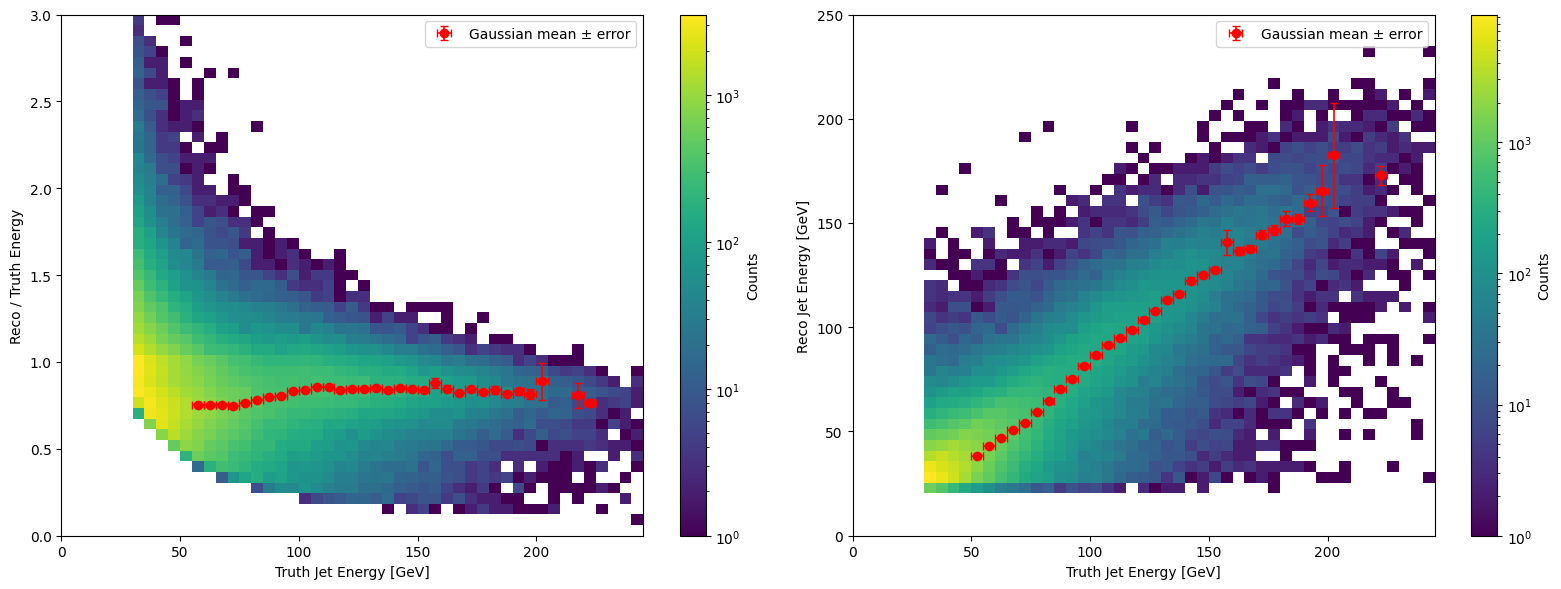

In [21]:
# --- 2D histogram parameters ---
x_bins = np.arange(0, 250, 5)
y_bins_ratio = np.linspace(0, 3, 50)
y_bins_reco = np.linspace(0, 250, 50)

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True)

# ----------------------
# (1) Energy scale (ratio)
# ----------------------
ax = axes[0]
hist_ratio = ax.hist2d(
    paired["energy_truth"],
    paired["energy_ratio"],
    bins=[x_bins, y_bins_ratio],
    cmap="viridis",
    norm=mcolors.LogNorm()
)
fig.colorbar(hist_ratio[3], ax=ax, label="Counts")
ax.set_xlabel("Truth Jet Energy [GeV]")
ax.set_ylabel("Reco / Truth Energy")

# overlay previously saved fit results
ax.errorbar(
    df_scale["center_energy"],
    df_scale["mu"],
    yerr=df_scale["mu_err"],
    xerr=0.5 * (df_scale["energy_range"].apply(lambda x: x[1]-x[0])),
    fmt='o',
    color='red',
    ecolor='red',
    elinewidth=1.2,
    capsize=3,
    label='Gaussian mean ± error'
)
ax.legend()

# ----------------------
# (2) Energy response (reco)
# ----------------------
ax = axes[1]
hist_reco = ax.hist2d(
    paired["energy_truth"],
    paired["energy_reco"],
    bins=[x_bins, y_bins_reco],
    cmap="viridis",
    norm=mcolors.LogNorm()
)
fig.colorbar(hist_reco[3], ax=ax, label="Counts")
ax.set_xlabel("Truth Jet Energy [GeV]")
ax.set_ylabel("Reco Jet Energy [GeV]")

# overlay previously saved fit results
ax.errorbar(
    df_response["center_energy"],
    df_response["mu"],
    yerr=df_response["mu_err"],
    xerr=0.5 * (df_response["energy_range"].apply(lambda x: x[1]-x[0])),
    fmt='o',
    color='red',
    ecolor='red',
    elinewidth=1.2,
    capsize=3,
    label='Gaussian mean ± error'
)
ax.legend()

plt.tight_layout()
plt.show()

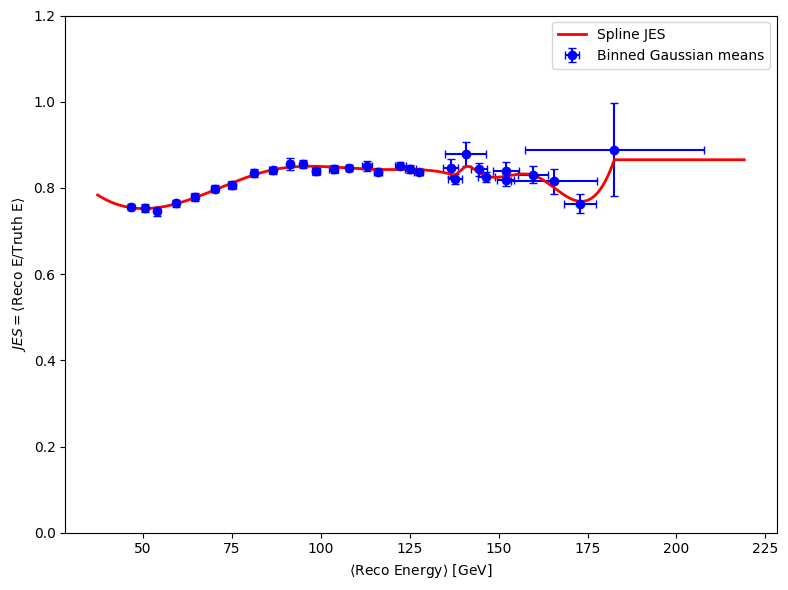

In [22]:
# --- Convert saved results to arrays ---
resp_bin_centers = df_response["center_energy"].values
resp_means = df_response["mu"].values
resp_sigmas = df_response["mu_err"].values

scale_bin_centers = df_scale["center_energy"].values
scale_means = df_scale["mu"].values
scale_sigmas = df_scale["mu_err"].values

# --- Match points by bin center ---
common_bins = np.intersect1d(resp_bin_centers, scale_bin_centers)

x_vals = []
y_vals = []
x_err = []
y_err = []

for b in common_bins:
    i_resp = np.where(resp_bin_centers == b)[0][0]
    i_scale = np.where(scale_bin_centers == b)[0][0]

    x_vals.append(resp_means[i_resp])        # x-axis: mean of reco energy
    x_err.append(resp_sigmas[i_resp])

    y_vals.append(scale_means[i_scale])      # y-axis: mean of energy scale
    y_err.append(scale_sigmas[i_scale])

x_vals = np.array(x_vals)
y_vals = np.array(y_vals)
x_err = np.array(x_err)
y_err = np.array(y_err)

# --- Optional: remove first point if desired ---
x_fit = x_vals[1:] if len(x_vals) > 1 else x_vals
y_fit = y_vals[1:] if len(y_vals) > 1 else y_vals
x_err_fit = x_err[1:] if len(x_vals) > 1 else x_err
y_err_fit = y_err[1:] if len(y_vals) > 1 else y_err

# --- Sort by x for spline ---
sort_idx = np.argsort(x_fit)
x_sorted = x_fit[sort_idx]
y_sorted = y_fit[sort_idx]
y_err_sorted = y_err_fit[sort_idx]

# --- Fit cubic spline ---
weights = 1 / np.maximum(y_err_sorted, 1e-6)
spline = UnivariateSpline(x_sorted, y_sorted, w=weights, k=3, s=10)

x_max = x_sorted.max()
y_max = spline(x_max)

def JES(reco_energy):
    reco_energy = np.asarray(reco_energy)
    out = np.empty_like(reco_energy, dtype=float)
    mask = reco_energy <= x_max
    out[mask] = spline(reco_energy[mask])
    out[~mask] = y_max
    return out

# --- Plot ---
plt.figure(figsize=(8,6))

plt.errorbar(
    x_fit,
    y_fit,
    xerr=x_err_fit,
    yerr=y_err_fit,
    fmt='o',
    color='blue',
    ecolor='blue',
    capsize=3,
    label='Binned Gaussian means'
)

x_fine = np.linspace(x_sorted.min()*0.8, x_sorted.max()*1.2, 600)
plt.plot(x_fine, JES(x_fine), 'r-', lw=2, label='Spline JES')

plt.xlabel(r"$\langle \mathrm{Reco\ Energy} \rangle$ [GeV]")
plt.ylabel(r"$JES = \langle \mathrm{Reco\ E} / \mathrm{Truth\ E} \rangle$")
plt.ylim(0, 1.2)
plt.legend()
plt.tight_layout()
plt.show()

In [23]:
# Apply JES correction to each reco energy
reco_energies = paired["energy_reco"].values

# JES returns the mean response at that energy → divide to correct
corrected_energies = reco_energies / JES(reco_energies)

# Store in new column
paired["energy_reco_corrected"] = corrected_energies

In [24]:
# --- Initialize lists ---
fit_results_response_corr = []
fit_results_scale_corr = []
recorded_response_corr = []
recorded_scale_corr = []

x_bins = np.arange(0, 250, 5)
min_points_for_fit = 20
n_hist_bins = 30

# --- Define corrected ratio ---
paired["energy_ratio_corrected"] = paired["energy_reco_corrected"] / paired["energy_truth"]

# --- Loop over energy bins ---
for i in range(len(x_bins) - 1):
    x_low, x_high = x_bins[i], x_bins[i + 1]
    mask = (paired["energy_truth"] >= x_low) & (paired["energy_truth"] < x_high)
    reco_corr_in_bin = paired.loc[mask, "energy_reco_corrected"].values
    ratio_corr_in_bin = paired.loc[mask, "energy_ratio_corrected"].values

    if len(reco_corr_in_bin) < min_points_for_fit:
        continue

    # ===============================
    # Corrected energy response fit
    # ===============================
    mu0 = np.mean(reco_corr_in_bin)
    sigma0 = np.std(reco_corr_in_bin)
    within_1sigma = (reco_corr_in_bin >= mu0 - sigma0) & (reco_corr_in_bin <= mu0 + sigma0)
    reco_fit_region = reco_corr_in_bin[within_1sigma]
    if len(reco_fit_region) < min_points_for_fit:
        continue

    counts, edges = np.histogram(reco_corr_in_bin, bins=n_hist_bins)
    bin_centers = 0.5 * (edges[:-1] + edges[1:])
    bin_widths = np.diff(edges)
    total_entries = counts.sum()
    density = counts / (total_entries * bin_widths)
    errors = np.sqrt(counts) / (total_entries * bin_widths)
    errors[errors == 0] = np.min(errors[errors > 0])

    fit_mask = (bin_centers >= mu0 - sigma0) & (bin_centers <= mu0 + sigma0)
    x_fit, y_fit, y_err = bin_centers[fit_mask], density[fit_mask], errors[fit_mask]
    if len(x_fit) < 3:
        continue

    p0 = [y_fit.max(), mu0, sigma0]
    try:
        popt, pcov = curve_fit(gauss, x_fit, y_fit, p0=p0, sigma=y_err, absolute_sigma=True)
    except (RuntimeError, ValueError):
        continue

    chi2_ndf = np.sum(((y_fit - gauss(x_fit, *popt)) / y_err) ** 2) / max(len(y_fit)-len(popt), 1)
    mu_fit, sigma_fit = popt[1], popt[2]
    mu_err, sigma_err = np.sqrt(np.diag(pcov))[1:3] if pcov.size else (np.nan, np.nan)
    center_energy = 0.5 * (x_low + x_high)

    if chi2_ndf <= 5 and (mu0 - sigma0 <= mu_fit <= mu0 + sigma0):
        recorded_response_corr.append({
            "center_energy": center_energy,
            "energy_range": (x_low, x_high),
            "mu": mu_fit,
            "mu_err": mu_err,
            "sigma": sigma_fit,
            "sigma_err": sigma_err,
            "chi2_ndf": chi2_ndf
        })
        fit_results_response_corr.append({
            "x_low": x_low,
            "x_high": x_high,
            "mu": mu_fit,
            "sigma": sigma_fit,
            "data": reco_corr_in_bin,
            "fit_region": (mu0 - sigma0, mu0 + sigma0),
            "popt": popt
        })

    # ===============================
    # Corrected energy scale fit
    # ===============================
    mu0_r = np.mean(ratio_corr_in_bin)
    sigma0_r = np.std(ratio_corr_in_bin)
    within_1sigma_r = (ratio_corr_in_bin >= mu0_r - sigma0_r) & (ratio_corr_in_bin <= mu0_r + sigma0_r)
    ratio_fit_region = ratio_corr_in_bin[within_1sigma_r]
    if len(ratio_fit_region) < min_points_for_fit:
        continue

    counts_r, edges_r = np.histogram(ratio_corr_in_bin, bins=n_hist_bins)
    bin_centers_r = 0.5 * (edges_r[:-1] + edges_r[1:])
    bin_widths_r = np.diff(edges_r)
    total_entries_r = counts_r.sum()
    density_r = counts_r / (total_entries_r * bin_widths_r)
    errors_r = np.sqrt(counts_r) / (total_entries_r * bin_widths_r)
    errors_r[errors_r == 0] = np.min(errors_r[errors_r > 0])

    fit_mask_r = (bin_centers_r >= mu0_r - sigma0_r) & (bin_centers_r <= mu0_r + sigma0_r)
    x_fit_r, y_fit_r, y_err_r = bin_centers_r[fit_mask_r], density_r[fit_mask_r], errors_r[fit_mask_r]
    if len(x_fit_r) < 3:
        continue

    p0_r = [y_fit_r.max(), mu0_r, sigma0_r]
    try:
        popt_r, pcov_r = curve_fit(gauss, x_fit_r, y_fit_r, p0=p0_r, sigma=y_err_r, absolute_sigma=True)
    except (RuntimeError, ValueError):
        continue

    chi2_ndf_r = np.sum(((y_fit_r - gauss(x_fit_r, *popt_r)) / y_err_r) ** 2) / max(len(y_fit_r)-len(popt_r), 1)
    mu_fit_r, sigma_fit_r = popt_r[1], popt_r[2]
    mu_err_r, sigma_err_r = np.sqrt(np.diag(pcov_r))[1:3] if pcov_r.size else (np.nan, np.nan)

    if chi2_ndf_r <= 5 and (mu0_r - sigma0_r <= mu_fit_r <= mu0_r + sigma0_r):
        recorded_scale_corr.append({
            "center_energy": center_energy,
            "energy_range": (x_low, x_high),
            "mu": mu_fit_r,
            "mu_err": mu_err_r,
            "sigma": sigma_fit_r,
            "sigma_err": sigma_err_r,
            "chi2_ndf": chi2_ndf_r
        })
        fit_results_scale_corr.append({
            "x_low": x_low,
            "x_high": x_high,
            "mu": mu_fit_r,
            "sigma": sigma_fit_r,
            "data": ratio_corr_in_bin,
            "fit_region": (mu0_r - sigma0_r, mu0_r + sigma0_r),
            "popt": popt_r
        })

# --- Convert to DataFrames ---
df_response_corr = pd.DataFrame(recorded_response_corr)
df_scale_corr = pd.DataFrame(recorded_scale_corr)


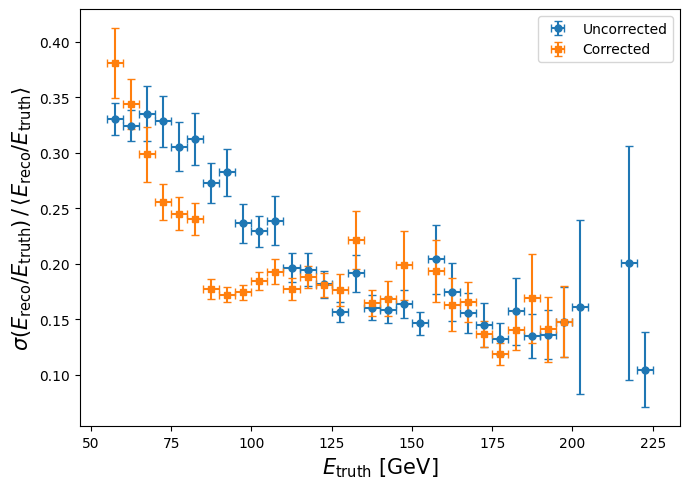

In [25]:
# --- Convert both datasets to DataFrames if needed ---
df_uncorr = pd.DataFrame(recorded_scale)
df_corr = pd.DataFrame(recorded_scale_corr)

def compute_resolution(df):
    x = np.array([(low + high) / 2 for low, high in df["energy_range"]])
    xerr = np.array([(high - low) / 2 for low, high in df["energy_range"]])
    mu = df["mu"].values
    sigma = df["sigma"].values
    mu_err = df["mu_err"].values
    sigma_err = df["sigma_err"].values
    resolution = sigma / mu
    resolution_err = resolution * np.sqrt((sigma_err / sigma)**2 + (mu_err / mu)**2)
    return x, xerr, resolution, resolution_err

# --- Compute for uncorrected and corrected ---
x_u, xerr_u, res_u, res_err_u = compute_resolution(df_uncorr)
x_c, xerr_c, res_c, res_err_c = compute_resolution(df_corr)

# --- Plot ---
plt.figure(figsize=(7, 5))
plt.errorbar(
    x_u, res_u, xerr=xerr_u, yerr=res_err_u,
    fmt='o', capsize=3, markersize=5, label='Uncorrected'
)
plt.errorbar(
    x_c, res_c, xerr=xerr_c, yerr=res_err_c,
    fmt='s', capsize=3, markersize=5, label='Corrected'
)

plt.xlabel(r"$E_{\mathrm{truth}}\ \mathrm{[GeV]}$", fontsize=15)
plt.ylabel(r"$\sigma(E_{\mathrm{reco}} / E_{\mathrm{truth}}) \,/\, \langle E_{\mathrm{reco}} / E_{\mathrm{truth}} \rangle$", fontsize=15)

plt.legend()
plt.tight_layout()
plt.show()


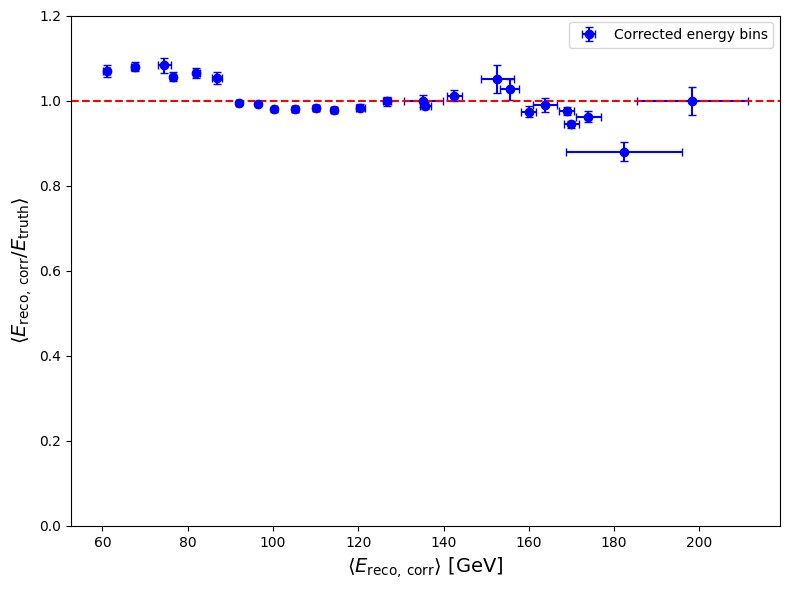

In [27]:
# --- Extract arrays from corrected fit results ---
resp_bin_centers = df_response_corr["center_energy"].values
resp_means = df_response_corr["mu"].values
resp_sigmas = df_response_corr["mu_err"].values

scale_bin_centers = df_scale_corr["center_energy"].values
scale_means = df_scale_corr["mu"].values
scale_sigmas = df_scale_corr["mu_err"].values

# --- Match by common bin centers ---
common_bins = np.intersect1d(resp_bin_centers, scale_bin_centers)

x_vals, y_vals, x_err, y_err = [], [], [], []

for b in common_bins:
    i_resp = np.where(resp_bin_centers == b)[0][0]
    i_scale = np.where(scale_bin_centers == b)[0][0]

    x_vals.append(resp_means[i_resp])   # corrected ⟨E_reco⟩
    x_err.append(resp_sigmas[i_resp])
    y_vals.append(scale_means[i_scale]) # corrected ⟨E_reco / E_truth⟩
    y_err.append(scale_sigmas[i_scale])

x_vals = np.array(x_vals)
y_vals = np.array(y_vals)
x_err = np.array(x_err)
y_err = np.array(y_err)

# --- Plot closure (no spline) ---
plt.figure(figsize=(8, 6))
plt.errorbar(
    x_vals, y_vals,
    xerr=x_err, yerr=y_err,
    fmt='o', capsize=3, color='blue',
    label='Corrected energy bins'
)

# Reference line for perfect closure
plt.axhline(1.0, color='red', linestyle='--', linewidth=1.5)

plt.xlabel(r"$\langle E_{\mathrm{reco,\,corr}}\rangle\ \mathrm{[GeV]}$", fontsize=14)
plt.ylabel(r"$\langle E_{\mathrm{reco,\,corr}} / E_{\mathrm{truth}} \rangle$", fontsize=14)
plt.ylim(0, 1.2)
plt.legend()
plt.tight_layout()
plt.show()
